In [16]:
import ortools
from datetime import datetime, timezone, timedelta
import pandas as pd
from pathlib import Path
import geopy.distance
from itertools import product
import fiona
import plotly.graph_objects as go
import numpy as np
from tqdm.autonotebook import tqdm as notebook_tqdm
notebook_tqdm.pandas()

In [17]:
CACHE_DIR = Path("../cache")

In [18]:
dfl, dfr = pd.read_parquet(CACHE_DIR / "left.parquet"), pd.read_parquet(CACHE_DIR / "right.parquet")

In [19]:
dfl

,timestamp,flightid,latitude,longitude,track,altitude,ground_speed,on_ground,callsign,source,registration,origin,destination,typecode,eta,vertical_speed,squawk,position_buffer,tzoffset,localtime
11251,2023-12-31 09:59:54+00:00,862939527,41.403652,-74.393600,181,7050,283,False,SIA22,0,9V-SGD,SIN,EWR,A359,0,0,0,[],-1 days +19:00:00,2023-12-31 04:59:54+00:00
16614,2023-12-31 09:59:58+00:00,862955005,43.356800,-72.347847,219,40000,463,False,UAL83,0,N29968,DEL,EWR,B789,0,0,0,[],-1 days +19:00:00,2023-12-31 04:59:58+00:00
35928,2023-12-31 11:59:57+00:00,862955676,-27.901108,-70.307007,198,41000,482,False,AFR406,0,F-HTYC,CDG,SCL,A359,0,0,0,[],-1 days +21:00:00,2023-12-31 08:59:57+00:00
26955,2023-12-31 10:59:58+00:00,862957857,45.513977,-73.695633,222,1000,144,False,ACA51,0,C-FSBV,DEL,YUL,B789,0,0,0,[],-1 days +19:00:00,2023-12-31 05:59:58+00:00
19612,2023-12-31 09:59:59+00:00,862959815,43.749516,-69.734146,219,38000,463,False,AAL293,0,N722AN,DEL,JFK,B77W,0,0,0,[],-1 days +19:00:00,2023-12-31 04:59:59+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289525,2024-01-01 10:59:52+00:00,863243773,12.042693,-179.372543,62,35000,474,False,UAL155,3,N34282,MAJ,HNL,B738,0,0,0,[],-1 days +12:00:00,2023-12-31 22:59:52+00:00
282351,2024-01-01 09:59:57+00:00,863244023,21.480789,-157.097198,55,21700,472,False,UAL3036,0,N783UA,HNL,SFO,B772,0,0,0,[],-1 days +14:00:00,2023-12-31 23:59:57+00:00
301253,2024-01-01 11:59:56+00:00,863245468,-3.757401,-173.889572,31,37004,502,False,FJI810,5,DQ-FAI,NAN,LAX,A359,0,0,0,[],-1 days +12:00:00,2023-12-31 23:59:56+00:00
299510,2024-01-01 11:59:52+00:00,863247483,-7.277201,-173.875977,39,37004,503,False,FJI880,5,DQ-FAM,NAN,YVR,A359,0,0,0,[],-1 days +12:00:00,2023-12-31 23:59:52+00:00


In [20]:
new_year_utc = datetime(2023, 12, 31, 23, 59, 59, tzinfo=timezone.utc)
dfl.loc[:, "seconds_to_ny"] = (new_year_utc - dfl.localtime).dt.total_seconds()

In [21]:
dfl = dfl.sort_values(by="seconds_to_ny")[:500]

In [22]:
dfl.loc[:, "deadline"] = (dfl.timestamp - dfl.timestamp.min()).dt.total_seconds()

In [23]:
dfl

,timestamp,flightid,latitude,longitude,track,altitude,ground_speed,on_ground,callsign,source,...,destination,typecode,eta,vertical_speed,squawk,position_buffer,tzoffset,localtime,seconds_to_ny,deadline
258387,2024-01-01 06:59:58+00:00,863212049,57.106293,-111.399826,23,31000,497,False,AIC180,0,...,BOM,B77L,0,0,0,[],-1 days +17:00:00,2023-12-31 23:59:58+00:00,1.0,21601.0
248360,2024-01-01 05:59:58+00:00,863209238,33.953384,-101.703468,283,34000,375,False,FFT3977,0,...,LAS,A321,0,0,0,[],-1 days +18:00:00,2023-12-31 23:59:58+00:00,1.0,18001.0
240643,2024-01-01 04:59:58+00:00,863209276,23.378347,-75.243584,119,37000,529,False,AAL995,0,...,GRU,B772,0,0,0,[],-1 days +19:00:00,2023-12-31 23:59:58+00:00,1.0,14401.0
230389,2024-01-01 03:59:58+00:00,863187306,45.982391,-58.979965,69,38975,531,False,VIR232G,0,...,LHR,B789,0,0,0,[],-1 days +20:00:00,2023-12-31 23:59:58+00:00,1.0,10801.0
258391,2024-01-01 06:59:58+00:00,863218174,28.410971,-109.894516,312,34025,387,False,VOI602,0,...,FAT,A20N,0,0,0,[],-1 days +17:00:00,2023-12-31 23:59:58+00:00,1.0,21601.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228365,2024-01-01 03:59:57+00:00,863203707,43.936283,-60.417938,72,37000,521,False,AFR7Z,0,...,CDG,B77W,0,0,0,[],-1 days +20:00:00,2023-12-31 23:59:57+00:00,2.0,10800.0
236829,2024-01-01 04:59:57+00:00,863203695,32.631302,-83.752815,157,34975,474,False,FFT3044,0,...,MCO,A21N,0,0,0,[],-1 days +19:00:00,2023-12-31 23:59:57+00:00,2.0,14400.0
237476,2024-01-01 04:59:57+00:00,863200568,28.346542,-81.938293,248,11500,347,False,JBU47,0,...,TPA,A320,0,0,0,[],-1 days +19:00:00,2023-12-31 23:59:57+00:00,2.0,14400.0
274441,2024-01-01 08:59:57+00:00,863226469,44.994644,-127.733459,333,33975,405,False,CXA830,0,...,XMN,B789,0,0,0,[],-1 days +15:00:00,2023-12-31 23:59:57+00:00,2.0,28800.0


## Try with ortools

In [24]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [93]:
AVG_SPEED = 100

data = {}

data["time_matrix"] = [
    [
        int(geopy.distance.geodesic(p1, p2).kilometers / AVG_SPEED)
        for p2 in dfl[['latitude', 'longitude']].to_numpy()
    ]
    for p1 in dfl[['latitude', 'longitude']].to_numpy()
]
data["time_windows"] = [
    (0, 10_000_000)
    for _ in range(len(data['time_matrix']))
]
data["num_vehicles"] = 2
data["depot"] = 0

In [94]:
# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(
    len(data["time_matrix"]), data["num_vehicles"], data["depot"]
)

In [96]:
# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    time_dimension = routing.GetDimensionOrDie("Time")
    total_time = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        while not routing.IsEnd(index):
            time_var = time_dimension.CumulVar(index)
            plan_output += (
                f"{manager.IndexToNode(index)}"
                f" Time({solution.Min(time_var)},{solution.Max(time_var)})"
                " -> "
            )
            index = solution.Value(routing.NextVar(index))
        time_var = time_dimension.CumulVar(index)
        plan_output += (
            f"{manager.IndexToNode(index)}"
            f" Time({solution.Min(time_var)},{solution.Max(time_var)})\n"
        )
        plan_output += f"Time of the route: {solution.Min(time_var)}min\n"
        print(plan_output)
        total_time += solution.Min(time_var)
    print(f"Total time of all routes: {total_time}min")

# Create and register a transit callback.
def time_callback(from_index, to_index):
    """Returns the travel time between the two nodes."""
    # Convert from routing variable Index to time matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data["time_matrix"][from_node][to_node]
transit_callback_index = routing.RegisterTransitCallback(time_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Add Time Windows constraint.
time = "Time"
routing.AddDimension(
    transit_callback_index,
    20,  # allow waiting time
    500,  # maximum time per vehicle
    False,  # Don't force start cumul to zero.
    time,
)
time_dimension = routing.GetDimensionOrDie(time)
# Add time window constraints for each location except depot.
for location_idx, time_window in enumerate(data["time_windows"]):
    if location_idx == data["depot"]:
        continue
    index = manager.NodeToIndex(location_idx)
    time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])
# Add time window constraints for each vehicle start node.
depot_idx = data["depot"]
for vehicle_id in range(data["num_vehicles"]):
    index = routing.Start(vehicle_id)
    time_dimension.CumulVar(index).SetRange(
        data["time_windows"][depot_idx][0], data["time_windows"][depot_idx][1]
    )

# Instantiate route start and end times to produce feasible times.
for i in range(data["num_vehicles"]):
    routing.AddVariableMinimizedByFinalizer(
        time_dimension.CumulVar(routing.Start(i))
    )
    routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(routing.End(i)))

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

# Print solution on console.
if solution:
    print_solution(data, manager, routing, solution)

Objective: 0
Route for vehicle 0:
0 Time(0,0) -> 92 Time(0,0) -> 136 Time(0,0) -> 178 Time(0,0) -> 196 Time(0,0) -> 244 Time(0,0) -> 140 Time(0,0) -> 266 Time(0,0) -> 218 Time(0,0) -> 390 Time(0,0) -> 1 Time(0,0) -> 32 Time(0,0) -> 494 Time(0,0) -> 373 Time(0,0) -> 367 Time(0,0) -> 231 Time(0,0) -> 419 Time(0,0) -> 459 Time(0,0) -> 155 Time(0,0) -> 242 Time(0,0) -> 275 Time(0,0) -> 437 Time(0,0) -> 84 Time(0,0) -> 289 Time(0,0) -> 336 Time(0,0) -> 274 Time(0,0) -> 458 Time(0,0) -> 102 Time(0,0) -> 52 Time(0,0) -> 482 Time(0,0) -> 479 Time(0,0) -> 247 Time(0,0) -> 328 Time(0,0) -> 91 Time(0,0) -> 359 Time(0,0) -> 346 Time(0,0) -> 229 Time(0,0) -> 177 Time(0,0) -> 128 Time(0,0) -> 184 Time(0,0) -> 37 Time(0,0) -> 93 Time(0,0) -> 13 Time(0,0) -> 236 Time(0,0) -> 8 Time(0,0) -> 6 Time(0,0) -> 80 Time(0,0) -> 49 Time(0,0) -> 245 Time(0,0) -> 12 Time(0,0) -> 392 Time(0,0) -> 116 Time(0,0) -> 497 Time(0,0) -> 372 Time(0,0) -> 56 Time(0,0) -> 131 Time(0,0) -> 380 Time(0,0) -> 217 Time(0,0) -> 

## Try with pyvrp

In [25]:
import pyvrp

In [26]:
from functools import cache

In [27]:
@cache
def dist(p1: tuple, p2: tuple) -> float:
    return geopy.distance.geodesic(p1, p2).kilometers

In [28]:
m = pyvrp.Model()

# time is in milliseconds
# distance is in meters
# speed is in meters / millisecond

# About mach 400 in meters / millisecond
AVG_SPEED = 1234.8 * 200 / 3.6 / 1000

depot_coords = dfl.iloc[dfl.deadline.argmin()][['latitude', 'longitude']]

depot = m.add_depot(x=depot_coords.longitude, y=depot_coords.latitude, name="depot_00")

m.add_vehicle_type(num_available=1, start_depot=depot, max_distance=70_000_000, tw_early=0, tw_late=1_000_000)
m.add_vehicle_type(num_available=1, start_depot=depot, max_distance=70_000_000, tw_early=0, tw_late=1_000_000)

# TW late is in milliseconds
clients = [
    m.add_client(x=cli['longitude'], y=cli['latitude'], tw_early=0, tw_late=cli['deadline'] * 1000 + 60_000)
    for _, cli in dfl.iterrows()
]

locations = [depot] + clients
for frm in locations:
    for to in locations:
        km = dist((frm.y, frm.x), (to.y, to.x))
        
        # Duration in milliseconds = (meters) / ( meters / milliseconds )
        dur = int(km * 1000 / AVG_SPEED)

        # print(f"{(frm.x, frm.y)} to {(to.x, to.y)} dur: {km * 1000 / AVG_SPEED}")
        
        assert (frm.x == to.x and frm.y == to.y) or (km != 0 and dur != 0)
        m.add_edge(frm, to, distance=km * 1000, duration=dur)

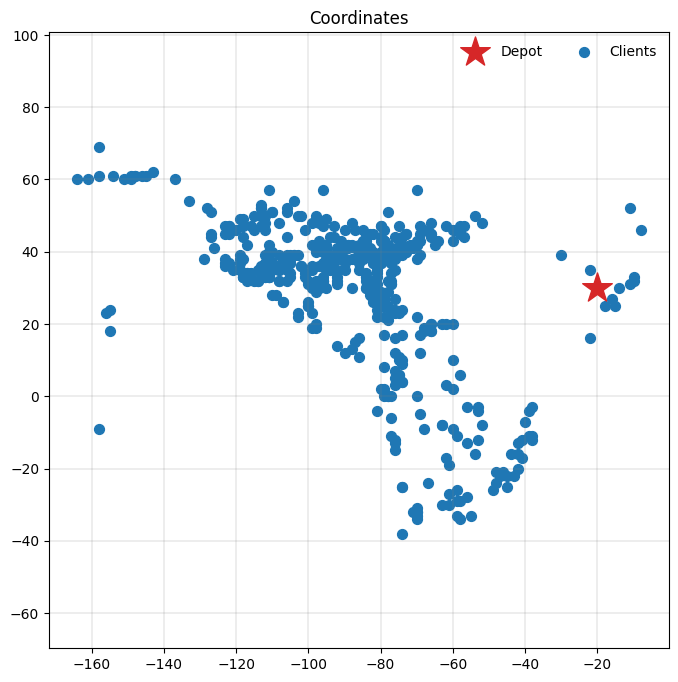

In [29]:
import matplotlib.pyplot as plt

from pyvrp.plotting import plot_coordinates

_, ax = plt.subplots(figsize=(8, 8))
plot_coordinates(m.data(), ax=ax)

In [30]:
from pyvrp.stop import MaxRuntime

res = m.solve(stop=MaxRuntime(60), display=True)  # one second

PyVRP v0.10.1

Solving an instance with:
    1 depot
    500 clients
    2 vehicles (2 vehicle types)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500     16s |  44 129947841 128216772 |  63 130714321 128432206
H    1000     23s |  53 128391374 128094274 |  25 128368843 127932330
H    1500     31s |  37 128313228 127974040 |  60 128378796 127796181
H    2000     38s |  54 128214299 127786737 |  59 128182536 127639896
H    2500     45s |  29 127879088 127756891 |  26 127819772 127608585
     3000     53s |  38 127929557 127756891 |  52 127840112 127608585

Search terminated in 60.00s after 3476 iterations.
Best-found solution has cost 127756891.

Solution results
    # routes: 2
   # clients: 500
   objective: 127756891
    distance: 127756891
    duration: 1862127
# iterations: 3476
    run-time: 60.00 seconds



In [31]:
res.best.distance()

127756891

In [32]:
res.best.duration()

1862127

In [33]:
res.best.time_warp()

0

In [34]:
min(res.best.routes()[1].visits())

1

In [35]:
# res.best.routes()[0].visits() # get route
dfl.iloc[[i - 1 for i in res.best.routes()[0].visits()]]

,timestamp,flightid,latitude,longitude,track,altitude,ground_speed,on_ground,callsign,source,...,destination,typecode,eta,vertical_speed,squawk,position_buffer,tzoffset,localtime,seconds_to_ny,deadline
201487,2024-01-01 00:59:58+00:00,863131854,27.301895,-16.785606,40,41000,482,False,AEA024,0,...,MAD,B788,0,0,0,[],-1 days +23:00:00,2023-12-31 23:59:58+00:00,1.0,1.0
198756,2024-01-01 00:59:57+00:00,863122882,25.749298,-15.767161,34,39000,474,False,IBE2602,0,...,BCN,A332,0,0,0,[],-1 days +23:00:00,2023-12-31 23:59:57+00:00,2.0,0.0
201348,2024-01-01 00:59:58+00:00,863135313,25.924755,-18.257271,41,40975,488,False,AEA026,0,...,MAD,B788,0,0,0,[],-1 days +23:00:00,2023-12-31 23:59:58+00:00,1.0,1.0
200825,2024-01-01 00:59:58+00:00,863165686,16.526882,-22.924887,196,34000,386,False,TAP43M,0,...,RAI,A321,0,0,0,[],-1 days +23:00:00,2023-12-31 23:59:58+00:00,1.0,1.0
228555,2024-01-01 03:59:57+00:00,863174595,20.954407,-60.049454,45,39000,528,False,IBE6454,0,...,MAD,A359,0,0,0,[],-1 days +20:00:00,2023-12-31 23:59:57+00:00,2.0,10800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219795,2024-01-01 02:59:57+00:00,863195746,-11.627655,-38.896717,19,37000,500,False,TAP072,0,...,LIS,A339,0,0,0,[],-1 days +21:00:00,2023-12-31 23:59:57+00:00,2.0,7200.0
219772,2024-01-01 02:59:57+00:00,863195282,-11.004949,-39.781544,25,37000,483,False,AZU8752,0,...,LIS,A332,0,0,0,[],-1 days +21:00:00,2023-12-31 23:59:57+00:00,2.0,7200.0
219774,2024-01-01 02:59:57+00:00,863196408,-7.106385,-40.974979,34,37000,454,False,TAM3734,0,...,FOR,A320,0,0,0,[],-1 days +21:00:00,2023-12-31 23:59:57+00:00,2.0,7200.0
219773,2024-01-01 02:59:57+00:00,863189544,-4.616772,-39.134674,27,18450,381,False,TAM3186,0,...,FOR,A20N,0,0,0,[],-1 days +21:00:00,2023-12-31 23:59:57+00:00,2.0,7200.0


In [57]:
dfl.columns

Index(['timestamp', 'flightid', 'latitude', 'longitude', 'track', 'altitude',
       'ground_speed', 'on_ground', 'callsign', 'source', 'registration',
       'origin', 'destination', 'typecode', 'eta', 'vertical_speed', 'squawk',
       'position_buffer', 'tzoffset', 'localtime', 'seconds_to_ny',
       'deadline'],
      dtype='object')

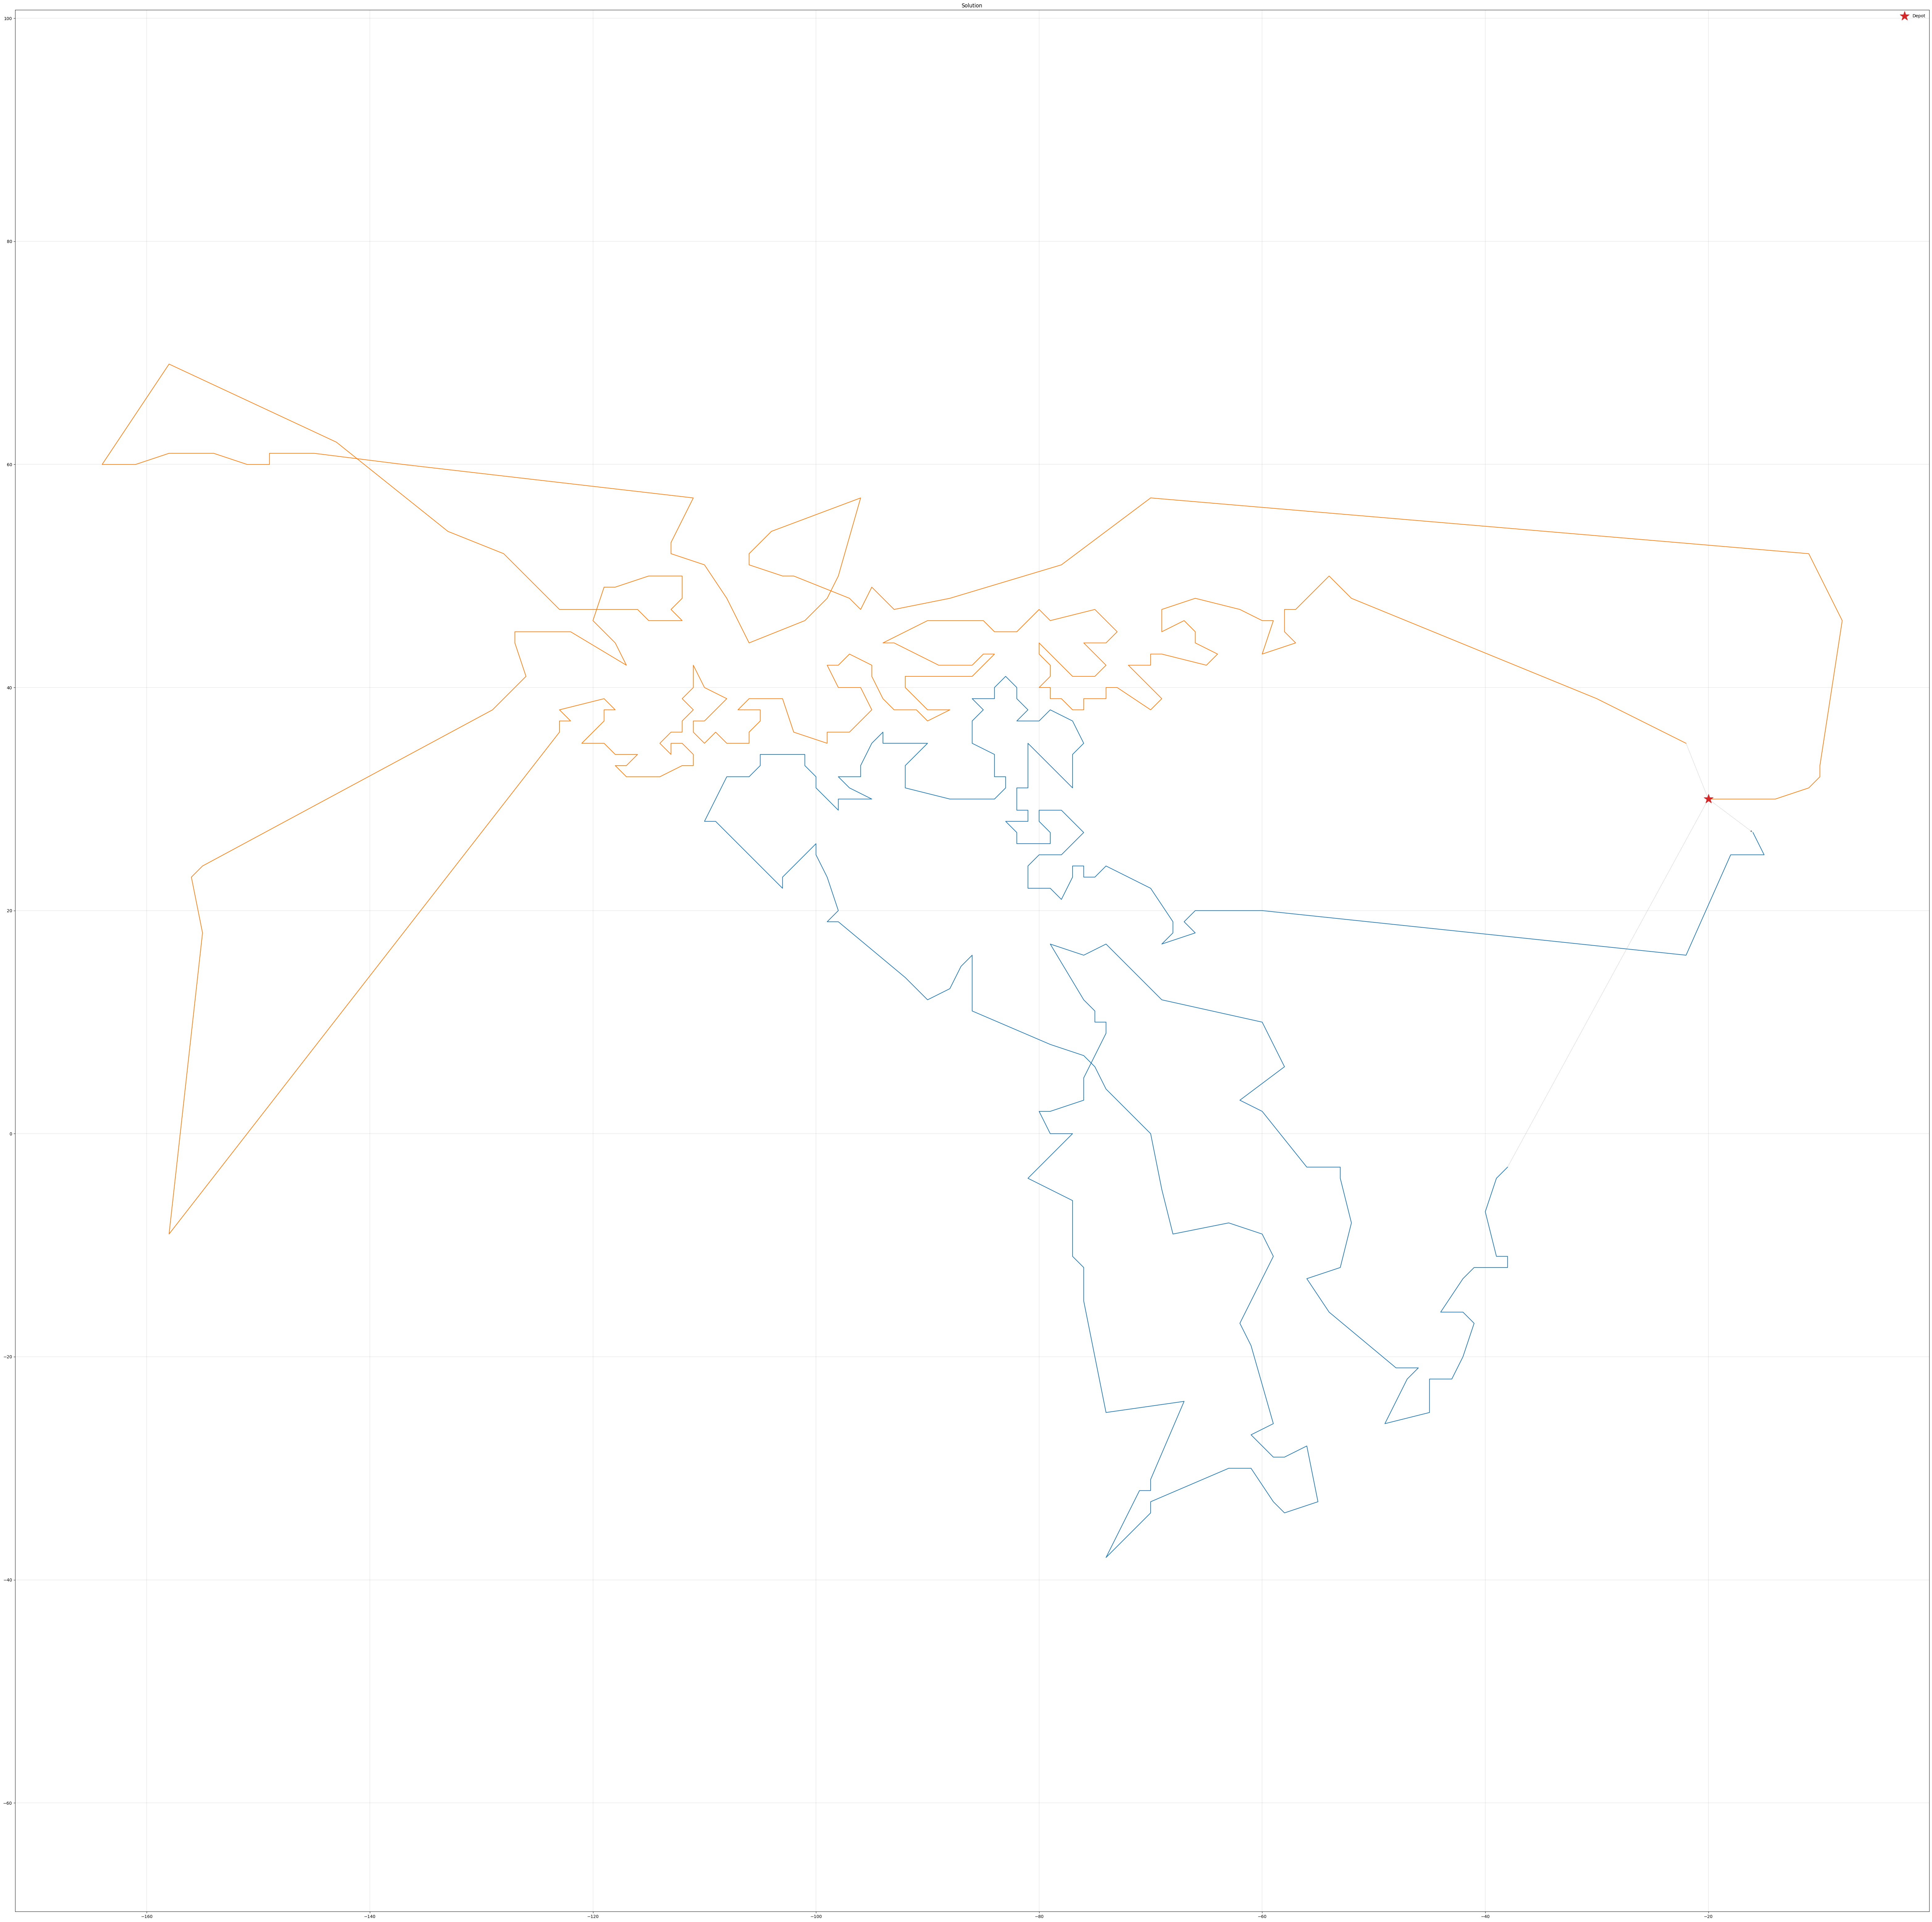

In [36]:
from pyvrp.plotting import plot_solution

_, ax = plt.subplots(figsize=(80, 80))
plot_solution(res.best, m.data(), ax=ax)

## Plot solution

In [7]:
# Take timezone polygons from https://github.com/nvkelso/natural-earth-vector/blob/master/10m_cultural/ne_10m_time_zones.shp
tz_polygons = []
with fiona.open("../ne_10m_time_zones.shp") as fr:
    for e in fr:
        tz_polygons.append(np.array(e.geometry.coordinates[0]))

In [ ]:
fig = go.Figure(layout={"autosize": False})

for tzp in tz_polygons:
    fig.add_trace(go.Scattergeo(
            lon = tzp[:, 0],
            lat = tzp[:, 1],
            mode = 'lines',
            line = dict(width = 1, color = 'purple'
        )))

for route in res.best.routes():
    planes_in_route = dfl.iloc[[i - 1 for i in route.visits()]]
    fig.add_trace(go.Scattergeo(
            lon = planes_in_route['longitude'],
            lat = planes_in_route['latitude'],
            mode = 'lines',
            line = dict(width = 2, color = 'red'
        )))
    for _, p in planes_in_route.iterrows():
        fig.add_trace(go.Scattergeo(
            lon = [p['longitude']],
            lat = [p['latitude']],
            text='✈️',
            hovertext=f"{p['origin']} -> {p['destination']} cs: {p['callsign']} reg: {p['registration']} equip: {p['typecode']} local time: {p['timestamp']}",
            mode='text',
            textfont={'size': 15}
        ))

fig.update_layout(
    title_text = 'Kek',
    showlegend = False,
    geo = dict(
        resolution = 50,
        showland = True,
        showlakes = True,
        landcolor = 'rgb(204, 204, 204)',
        countrycolor = 'rgb(204, 204, 204)',
        lakecolor = 'rgb(255, 255, 255)',
        projection_type = "equirectangular",
        coastlinewidth = 2,
        lataxis = dict(
            range = [dfl.latitude.min() - 2, dfl.latitude.max() + 2],
            showgrid = True,
            dtick = 10
        ),
        lonaxis = dict(
            range = [dfl.longitude.min() - 2, dfl.longitude.max() + 2],
            showgrid = True,
            dtick = 20
        ),
    )
)

fig.layout.height = 1000
fig.layout.width = 1100
fig.show()